In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [2]:
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
import torch.nn as nn
import time
import itertools
from datetime import datetime
from rdkit import Chem
import csv
import copy

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import functional as F
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from rdkit.Chem import Crippen, QED
from joblib import Parallel, delayed

from utils.config import Config
from utils.config import set_random_seed
from learner.dataset import FragmentDataset
from learner.model import Loss, Frag2Mol
from learner.trainer import Trainer
from molecules.conversion import (
    mols_from_smiles, mols_to_smiles, mol_to_smiles, canonicalize)
from molecules.fragmentation import fragment_iterative, reconstruct
from molecules.properties import add_property
from molecules.structure import (
    add_atom_counts, add_bond_counts, add_ring_counts)
from molecules.sascorer.sascorer import calculateScore
from learner.skipgram import Vocab

/home/teddy_t/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plot Latent Space

In [3]:
config = pickle.load(open('RUNS/2022-08-08@20:20:02-LAPTOP-E1483HNR-CHEMBL/config/config.pkl', "rb"))
vocab = pickle.load(open('RUNS/2022-08-08@20:20:02-LAPTOP-E1483HNR-CHEMBL/config/vocab.pkl', "rb"))
dataset = FragmentDataset(config)
vocab = dataset.get_vocab()
model = Frag2Mol(config, vocab)
#device = torch.device('cuda')
#model = model.to(device)

Vocab created/loaded. Size: 90175. Effective size: 90175. Time elapsed: 00:00:00.


In [4]:
load_last = config.get('load_last')
trainer, epoch = Trainer.load(config, vocab, last=load_last)
model = trainer.model

loading best_loss.pt at epoch 20...


In [5]:
model

Frag2Mol(
  (embedder): Embedding(90175, 64)
  (latent2rnn): Linear(in_features=100, out_features=64, bias=True)
  (encoder): Encoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2mean): Linear(in_features=128, out_features=100, bias=True)
    (rnn2logv): Linear(in_features=128, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (rnn): GRU(64, 64, num_layers=2, batch_first=True, dropout=0.3)
    (rnn2out): Linear(in_features=64, out_features=90175, bias=True)
  )
  (mlp): MLP(
    (layers): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): ReLU()
      (4): Linear(in_features=32, out_features=1, bias=True)
    )
  )
)

In [6]:
loader = dataset.get_loader()
#mu_stack = torch.empty((32,100))
#latent_output = torch.empty((32,100))
data_sample = []
rnn2mean_weight = model.encoder.rnn2mean.weight

Data loaded. Size: 103491. Time elapsed: 00:00:00.


/home/teddy_t/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
rnn2mean_weight

Parameter containing:
tensor([[ 0.0621, -0.0392,  0.0294,  ..., -0.0526,  0.0293, -0.0486],
        [ 0.0308, -0.0068,  0.0622,  ..., -0.0364, -0.0348,  0.0736],
        [ 0.0303, -0.0484, -0.0360,  ..., -0.0290, -0.0037,  0.0666],
        ...,
        [-0.0392, -0.0008, -0.0449,  ...,  0.0891,  0.0552, -0.0401],
        [ 0.0887, -0.0270,  0.0727,  ..., -0.0788, -0.0383, -0.0655],
        [-0.0337, -0.0394,  0.0813,  ...,  0.0655, -0.0147,  0.0148]],
       device='cuda:0', requires_grad=True)

In [8]:
for idx, (src, tgt, lengths, data) in enumerate(loader):
    ###
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred = model.forward(src, lengths)
    
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
        pred_stack = pred
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_stack = torch.cat((pred_stack, pred), 0)
    if idx == 0 or idx % 10000 == 0:
        print(len(mu_stack))
    if len(mu_stack) > 100000:
        break

32


In [9]:
data_sample_index = [item for sublist in data_sample for item in sublist]

In [11]:
pred_stack.cpu().detach().numpy()

array([3.577537 , 3.576546 , 3.575504 , ..., 3.6368408, 3.6368454,
       3.6378698], dtype=float32)

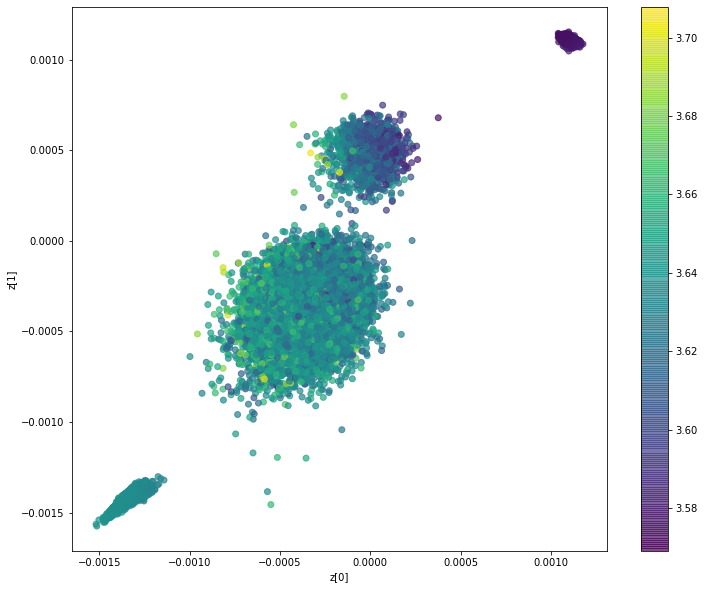

In [12]:
plt.figure(figsize=(12, 10))
plt.scatter(mu_stack[:, 1].cpu().detach().numpy(), mu_stack[:, 2].cpu().detach().numpy(), c=pred_stack.cpu().detach().numpy(), alpha=0.7)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.colorbar()
#plt.xlim(-0.0025, 0.003)
#plt.ylim(-0.0025, 0.0025)
plt.show()

In [13]:
x = mu_stack.cpu().detach().numpy()
x = StandardScaler().fit_transform(x)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

In [14]:
principalDf

,pc1,pc2
0,21.128153,-2.429533
1,21.213844,-1.826611
2,20.680397,-2.314160
3,20.543255,-2.310689
4,20.735634,-2.443031
...,...,...
100027,-8.645601,-0.501651
100028,-8.620724,-0.633658
100029,-8.559887,-0.187798
100030,-8.537151,-0.569871


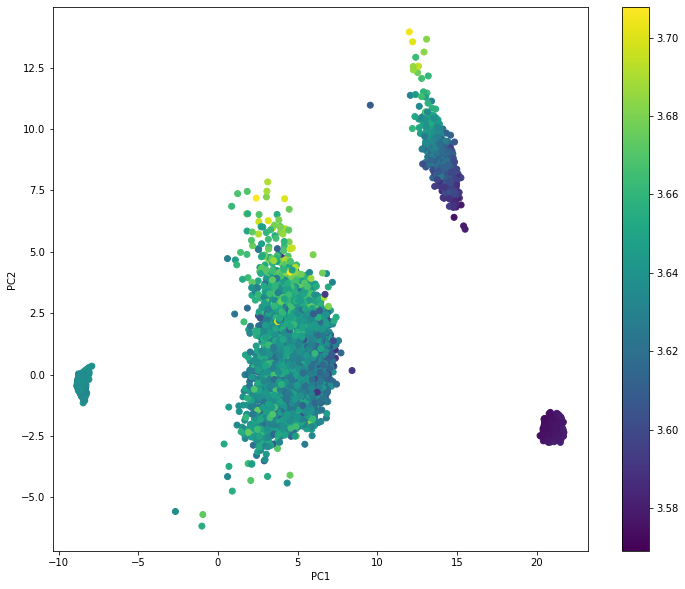

In [15]:
plt.figure(figsize=(12, 10))
plt.scatter(principalDf['pc1'].to_numpy(), 
            principalDf['pc2'].to_numpy(), 
            c=pred_stack.cpu().detach().numpy())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar()
#plt.xlim(-0.08, -0.075)
#plt.ylim(-0.055, -0.05)
plt.show()

# Sampling from Latent Space

In [16]:
model.latent_size

100

In [18]:
model.hidden_layers

2

In [46]:
torch.randn((model.hidden_layers, 100, model.latent_size)).shape

torch.Size([2, 100, 100])

In [5]:
model = model.cpu()
model.eval()

hidden_layers = model.hidden_layers
hidden_size = model.hidden_size

def row_filter(row):
    return (row == vocab.EOS).any()

count = 0
total_time = 0
batch_size = 100
samples, sampled = [], 0

max_length = config.get('max_length')
temperature = config.get('temperature')

seed = set_random_seed()
config.set('sampling_seed', seed)
print("Sampling seed:", config.get('sampling_seed'))
#z = model.encoder.sample_normal(batch_size)

Sampling seed: 3843559103


In [6]:
# get the initial state
state = model.latent2rnn(z.cpu())
state = state.view(hidden_layers, batch_size, hidden_size)

NameError: name 'z' is not defined

In [ ]:
state.shape

In [7]:
def update(save_to, sample, running_seqs, step):
    # select only still running
    running_latest = save_to[running_seqs]
    # update token at step position
    running_latest[:, step] = sample.data
    # save back
    save_to[running_seqs] = running_latest

    return save_to

In [8]:
def dump_samples(config, samples):
    columns = ["smiles", "fragments", "n_fragments"]
    df = pd.DataFrame(samples, columns=columns)
    date = datetime.now().strftime('%Y-%m-%d@%X')
    filename = config.path('samples') / f"{date}_{len(samples)}.csv"
    df.to_csv(filename)

In [9]:
def generate_molecules(samples, vocab):
    result = []
    num_samples = samples.shape[0]

    for idx in range(num_samples):
        frag_smiles = vocab.translate(samples[idx, :])
        frag_smiles = remove_consecutive(frag_smiles)
        #print(frag_smiles)

        if len(frag_smiles) <= 1:
            continue

        try:
            frag_mols = mols_from_smiles(frag_smiles)
            mol, frags = reconstruct(frag_mols)
            #print(mol)
            if mol is not None:
                smiles = mol_to_smiles(mol)
                num_frags = len(frags)
                frags = " ".join(mols_to_smiles(frags))
                result.append((smiles, frags, num_frags))
        except Exception:
            continue

    return result

In [10]:
def remove_consecutive(fragments):
    return [i for i, _ in itertools.groupby(fragments)]

In [11]:
num_samples = config.get('num_samples')
save_results=True

In [12]:
model = model.cpu()
model.eval()

hidden_layers = model.hidden_layers
hidden_size = model.hidden_size

def row_filter(row):
    return (row == vocab.EOS).any()

count = 0
total_time = 0
batch_size = 100
samples, sampled = [], 0

max_length = config.get('max_length')
temperature = config.get('temperature')

seed = set_random_seed()
config.set('sampling_seed', seed)
print("Sampling seed:", config.get('sampling_seed'))

with torch.no_grad():
    while len(samples) < num_samples:
        start = time.time()

        # sample vector from latent space
        z = model.encoder.sample_normal(batch_size).cpu()
        #mean_tensor = torch.ones(100, 100) * 0.001
        #std_tensor = torch.ones(100, 100) * 0.001
        #z = torch.stack([torch.normal(mean_tensor, std_tensor),torch.normal(mean_tensor, std_tensor)], axis = 0)
        
        # get the initial state
        state = model.latent2rnn(z)
        state = state.view(hidden_layers, batch_size, hidden_size)

        # all idx of batch
        sequence_idx = torch.arange(0, batch_size).long()

        # all idx of batch which are still generating
        running = torch.arange(0, batch_size).long()
        sequence_mask = torch.ones(batch_size, dtype=torch.bool)

        # idx of still generating sequences
        # with respect to current loop
        running_seqs = torch.arange(0, batch_size).long()
        lengths = [1] * batch_size

        generated = torch.Tensor(batch_size, max_length).long()
        generated.fill_(vocab.PAD)

        inputs = Variable(torch.Tensor(batch_size).long())
        inputs.fill_(vocab.SOS).long()

        step = 0

        while(step < max_length and len(running_seqs) > 0):
            inputs = inputs.unsqueeze(1)
            emb = model.embedder(inputs)
            scores, state = model.decoder(emb, state, lengths)
            scores = scores.squeeze(1)

            probs = F.softmax(scores / temperature, dim=1)
            inputs = torch.argmax(probs, 1).reshape(1, -1)

            # save next input
            generated = update(generated, inputs, running, step)
            # update global running sequence
            sequence_mask[running] = (inputs != vocab.EOS)
            running = sequence_idx.masked_select(sequence_mask)

            # update local running sequences
            running_mask = (inputs != vocab.EOS)
            running_seqs = running_seqs.masked_select(running_mask)

            # prune input and hidden state according to local update
            run_length = len(running_seqs)
            if run_length > 0:
                inputs = inputs.squeeze(0)
                inputs = inputs[running_seqs]
                state = state[:, running_seqs]
                running_seqs = torch.arange(0, run_length).long()

            lengths = [1] * run_length
            step += 1

        new_samples = generated.numpy()
        #print(new_samples)
        mask = np.apply_along_axis(row_filter, 1, new_samples)
        samples += generate_molecules(new_samples[mask], vocab)

        end = time.time() - start
        total_time += end

        if len(samples) > sampled:
            sampled = len(samples)
            count = 0 
        else: 
            count += 1

        if len(samples) % 1000 < 50:
            elapsed = time.strftime("%H:%M:%S", time.gmtime(end))
            print(f'Sampled {len(samples)} molecules. '
                  f'Time elapsed: {elapsed}')

        if count >= 1000:
            break 

if save_results:
    dump_samples(config, samples)

elapsed = time.strftime("%H:%M:%S", time.gmtime(total_time))
print(f'Done. Total time elapsed: {elapsed}.')


Sampling seed: 2142808436


[16:23:59] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:23:59] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:23:59] Explicit valence for atom # 4 O, 3, is greater than permitted


0 *c1ccccc1 *NCCc1cc(-c2c[nH]c3cccc(Br)c23)nc(N)n1
0 Nc1nc(CCNc2ccccc2)cc(-c2c[nH]c3cccc(Br)c23)n1


[16:24:00] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 2 molecules. Time elapsed: 00:00:04


[16:24:03] Can't kekulize mol.  Unkekulized atoms: 4 6 8 26
[16:24:04] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:04] Explicit valence for atom # 4 N, 4, is greater than permitted


0 *C1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CCC12C *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNC1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CCC12C


[16:24:05] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:05] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 3 molecules. Time elapsed: 00:00:03


[16:24:05] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:06] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *N1C2=NCCN2C(=O)c2[nH]c(Br)nc21 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNN1C2=NCCN2C(=O)c2[nH]c(Br)nc21


[16:24:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:07] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *NC(*)=O *NCCC(C)CCCCCCC
0 *C(=O)NNCCC(C)CCCCCCC
1 *S(=O)(=O)c1ccc(Nc2nc(-c3ccc(-c4ccccc4)cc3)cs2)cc1 *C(=O)NNCCC(C)CCCCCCC
1 CCCCCCCC(C)CCNNC(=O)S(=O)(=O)c1ccc(Nc2nc(-c3ccc(-c4ccccc4)cc3)cs2)cc1


[16:24:08] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1nc(Nc2ccccc2)c2ncn(CC(=O)O)c2n1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1nc(Nc2ccccc2)c2ncn(CC(=O)O)c2n1
Sampled 6 molecules. Time elapsed: 00:00:04


[16:24:11] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:11] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *N1CCC2(CC1)CC(CC(=O)NCC1CC1)c1ccccc12 *NCCC(C)O
0 CC(O)CCNN1CCC2(CC1)CC(CC(=O)NCC1CC1)c1ccccc12


[16:24:12] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:13] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:13] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 7 molecules. Time elapsed: 00:00:04
0 *N1CCC(c2ccc3[nH]ccc3c2)CC1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNN1CCC(c2ccc3[nH]ccc3c2)CC1


[16:24:15] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:16] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:18] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:18] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:20] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 8 molecules. Time elapsed: 00:00:07
0 *NC(*)=O *NCCC(C)CCCCCCC
0 *C(=O)NNCCC(C)CCCCCCC
1 *C(O)CN1CCC(NCc2cnc3snnc3c2)C(F)C1 *C(=O)NNCCC(C)CCCCCCC
1 CCCCCCCC(C)CCNNC(=O)C(O)CN1CCC(NCc2cnc3snnc3c2)C(F)C1


[16:24:22] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:24] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:24:24] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:25] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:26] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:26] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 9 molecules. Time elapsed: 00:00:06


[16:24:28] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:29] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:24:29] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:24:31] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:32] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *NC(=N)c1ccc(-c2cc3ccc(C(=N)NC(C)C)cc3o2)cc1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNNC(=N)c1ccc(-c2cc3ccc(C(=N)NC(C)C)cc3o2)cc1


[16:24:33] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 10 molecules. Time elapsed: 00:00:06


[16:24:34] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *N1C(CCc2ccc(O)cc2)CCCC1CCc1ccc(O)cc1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNN1C(CCc2ccc(O)cc2)CCCC1CCc1ccc(O)cc1


[16:24:35] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:36] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:38] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:38] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:24:39] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:40] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 11 molecules. Time elapsed: 00:00:06


[16:24:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:42] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 23 24 25
[16:24:42] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:43] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1cc(-c2nc(C)c(C)[nH]2)co1 *NCCC(C)O
0 Cc1nc(-c2coc(NCCC(C)O)c2)[nH]c1C
Sampled 12 molecules. Time elapsed: 00:00:03
0 *C12CCC(C(=C)C)C1C1CCC3C4(C)CC(OC(=O)c5ccc(O)cc5)C(O)C(C)(C)C4CCC3(C)C1(C)CC2 *NCCC(C)CCCCCCC
0 C=C(C)C1CCC2(NCCC(C)CCCCCCC)CCC3(C)C(CCC4C5(C)CC(OC(=O)c6ccc(O)cc6)C(O)C(C)(C)C5CCC43C)C12
0 *Nc1ccc2c(c1)C1CNCC2C1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNNc1ccc2c(c1)C1CNCC2C1


[16:24:46] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:48] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *CCC(C(=O)NCc1cc(C(F)(F)F)cc(C(F)(F)F)c1)C(C)O *NCCC(C)O
0 CC(O)CCNCCC(C(=O)NCc1cc(C(F)(F)F)cc(C(F)(F)F)c1)C(C)O
Sampled 15 molecules. Time elapsed: 00:00:04


[16:24:50] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:51] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:51] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 15 molecules. Time elapsed: 00:00:04


[16:24:53] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:53] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:55] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10
[16:24:55] Explicit valence for atom # 11 C, 5, is greater than permitted
[16:24:55] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:56] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:56] Can't kekulize mol.  Unkekulized atoms: 4 8 9 10 11 18 21 22 23 24
[16:24:57] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 24 25 26
[16:24:57] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:24:58] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *CC(CC)(CC)NC(=O)C(Cc1ccc(OC)c(OC)c1)Nc1ccc(C#N)c2ccccc12 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCC(CC)(CC)NC(=O)C(Cc1ccc(OC)c(OC)c1)Nc1ccc(C#N)c2ccccc12
Sampled 16 molecules. Time elapsed: 00:00:05
0 *S(=O)(=O)c1cccc2c1OCC(c1nc3ccc(-c4ccnc(N)n4)cc3[nH]1)C2 *NCCC(C)O
0 CC(O)CCNS(=O)(=O)c1cccc2c1OCC(c1nc3ccc(-c4ccnc(N)n4)cc3[nH]1)C2
0 *Nc1cccc(NC(=O)C2C3CC4OC(=O)C2C4C3)c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNNc1cccc(NC(=O)C2C3CC4OC(=O)C2C4C3)c1


[16:25:02] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:02] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 23 24 25
[16:25:03] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 19 molecules. Time elapsed: 00:00:05


[16:25:04] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:04] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *NC(c1ccco1)c1cc(Cl)c2cccnc2c1OC *NCCC(C)O
0 COc1c(C(NNCCC(C)O)c2ccco2)cc(Cl)c2cccnc12
0 *c1ccc(N2CCN(C3CCCC3)CC2)cc1 *NCCC(C)O
0 CC(O)CCNc1ccc(N2CCN(C3CCCC3)CC2)cc1


[16:25:05] Explicit valence for atom # 6 O, 3, is greater than permitted
[16:25:05] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:07] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *CC(NC(=O)c1ccccc1-c1ccccc1C(=O)NC(Cc1c[nH]cn1)C(=O)OC)C(=O)OC *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCC(NC(=O)c1ccccc1-c1ccccc1C(=O)NC(Cc1c[nH]cn1)C(=O)OC)C(=O)OC
Sampled 22 molecules. Time elapsed: 00:00:04


[16:25:09] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *=NC(CO)c1cccc(C(F)F)c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCN=NC(CO)c1cccc(C(F)F)c1
0 *Nc1ccc(NC(=O)c2sc3sccc3c2Cl)cc1 *NCCC(C)O
0 CC(O)CCNNc1ccc(NC(=O)c2sc3sccc3c2Cl)cc1


[16:25:09] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:10] Can't kekulize mol.  Unkekulized atoms: 5 16 17 18 19 22 23
[16:25:11] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:13] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:13] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 24 molecules. Time elapsed: 00:00:04


[16:25:14] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *NC(*)=O *NCCC(C)CCCCCCC
0 *C(=O)NNCCC(C)CCCCCCC
1 *n1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(=O)n2ncnc12 *C(=O)NNCCC(C)CCCCCCC
1 CCCCCCCC(C)CCNNC(=O)n1cc(C(=O)NC23CC4CC(CC(C4)C2)C3)c(=O)n2ncnc12
0 *C(CC)N=C(O)CC(N)C(C)C *NCCC(C)O
0 CCC(N=C(O)CC(N)C(C)C)NCCC(C)O


[16:25:17] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:18] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 26 molecules. Time elapsed: 00:00:05
Sampled 27 molecules. Time elapsed: 00:00:04


[16:25:23] Can't kekulize mol.  Unkekulized atoms: 14 42
[16:25:23] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *Cc1cnc(C2CCN(C(=O)c3cc(F)cc(F)c3)C2)[nH]1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCc1cnc(C2CCN(C(=O)c3cc(F)cc(F)c3)C2)[nH]1


[16:25:25] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:25] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:25] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:26] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:27] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 28 molecules. Time elapsed: 00:00:04


[16:25:29] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:29] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:25:30] Explicit valence for atom # 4 S, 7, is greater than permitted


Sampled 28 molecules. Time elapsed: 00:00:03
0 *C(=O)c1[nH]nc2c1C(=O)N(CC)C2=O *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNC(=O)c1[nH]nc2c1C(=O)N(CC)C2=O


[16:25:32] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *COc1cc([N+](=O)[O-])ccc1OC *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCOc1cc([N+](=O)[O-])ccc1OC


[16:25:32] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:33] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1cc(Cl)c(OCc2ccc(OC3CCOCC3)cc2)c(OC)c1 *NCCC(C)O
0 COc1cc(NCCC(C)O)cc(Cl)c1OCc1ccc(OC2CCOCC2)cc1


[16:25:34] Can't kekulize mol.  Unkekulized atoms: 6 7 9
[16:25:34] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 31 molecules. Time elapsed: 00:00:04


[16:25:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:38] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:38] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:39] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 31 molecules. Time elapsed: 00:00:03
0 *c1cccc2nc(C)c(NC3(C)CCCCC3)nc12 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1cccc2nc(C)c(NC3(C)CCCCC3)nc12


[16:25:42] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:25:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:44] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:44] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:44] Explicit valence for atom # 4 O, 3, is greater than permitted


Sampled 32 molecules. Time elapsed: 00:00:05


[16:25:46] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:48] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *OC(O)=C1C(C)=Nc2ncnn2C1c1ccc(OC)c(OC)c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNOC(O)=C1C(C)=Nc2ncnn2C1c1ccc(OC)c(OC)c1


[16:25:50] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:50] Explicit valence for atom # 4 O, 3, is greater than permitted


Sampled 34 molecules. Time elapsed: 00:00:06


[16:25:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:52] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:53] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:25:54] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:56] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 35 molecules. Time elapsed: 00:00:04


[16:25:56] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:57] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *OC(=O)c1cc(C=Cc2ccc(OC)nc2)on1 *NCCC(C)O
0 COc1ccc(C=Cc2cc(C(=O)ONCCC(C)O)no2)cn1


[16:25:58] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:25:58] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *C(=O)C(CC1CCCCC1)Nc1nc2ccc(Cl)cc2o1 *NCCC(C)O
0 CC(O)CCNC(=O)C(CC1CCCCC1)Nc1nc2ccc(Cl)cc2o1


[16:25:59] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 37 molecules. Time elapsed: 00:00:03
0 *c1ccc2[nH]c3ncnc(NC4CCCCCC4)c3c2c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1ccc2[nH]c3ncnc(NC4CCCCCC4)c3c2c1


[16:26:02] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:03] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1cc(C(C)(C)C#N)no1 *NCCC(C)O
0 CC(O)CCNc1cc(C(C)(C)C#N)no1


[16:26:03] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:04] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *NC(*)=O *NCCC(C)CCCCCCC
0 *C(=O)NNCCC(C)CCCCCCC
1 *c1nnc(SCC(=O)Nc2ccccc2Cl)[nH]1 *C(=O)NNCCC(C)CCCCCCC
1 CCCCCCCC(C)CCNNC(=O)c1nnc(SCC(=O)Nc2ccccc2Cl)[nH]1


[16:26:05] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:26:06] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *CCOc1cccc(-c2cc3cc(C4=NCCN4)ccc3o2)c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCCOc1cccc(-c2cc3cc(C4=NCCN4)ccc3o2)c1
Sampled 41 molecules. Time elapsed: 00:00:06


[16:26:06] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:08] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:08] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:09] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *OC(c1ccc(F)cc1)C1CNCCO1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNOC(c1ccc(F)cc1)C1CNCCO1
0 *c1nnc(SCc2ccc(C)cc2)n1Cc1ccc(NC(=O)c2ccccc2C(=O)O)cc1 *NCCC(C)O
0 Cc1ccc(CSc2nnc(NCCC(C)O)n2Cc2ccc(NC(=O)c3ccccc3C(=O)O)cc2)cc1
Sampled 43 molecules. Time elapsed: 00:00:05
0 *c1cn2c3c(c(N4CCSCC4)c(F)cc3c1=O)SCC2 *NCCC(C)O
0 CC(O)CCNc1cn2c3c(c(N4CCSCC4)c(F)cc3c1=O)SCC2


[16:26:12] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:13] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:13] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:14] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:26:16] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 44 molecules. Time elapsed: 00:00:05


[16:26:17] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:17] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:26:18] Explicit valence for atom # 5 C, 5, is greater than permitted
[16:26:21] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:26:21] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 44 molecules. Time elapsed: 00:00:05


[16:26:24] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:25] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:25] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 44 molecules. Time elapsed: 00:00:03


[16:26:27] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:27] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:29] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 44 molecules. Time elapsed: 00:00:03
0 *n1cc(-c2cccc(Cl)c2Cl)nn1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNn1cc(-c2cccc(Cl)c2Cl)nn1


[16:26:31] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:31] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:31] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *C1CN(c2ccc(F)c(-c3n[nH]c4ncccc34)n2)CC(C)N1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNC1CN(c2ccc(F)c(-c3n[nH]c4ncccc34)n2)CC(C)N1


[16:26:33] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccc(S(=O)(=O)c2cc(F)cc(OC)c2)cc1 *NCCC(C)O
0 COc1cc(F)cc(S(=O)(=O)c2ccc(NCCC(C)O)cc2)c1
0 *N[S+](=O)([O-])c1ccc(N(C)CCCN(C)C)nc1 *NCCC(C)O
0 CC(O)CCNN[S+](=O)([O-])c1ccc(N(C)CCCN(C)C)nc1


[16:26:34] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
[16:26:34] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 48 molecules. Time elapsed: 00:00:04
0 *C1CC(C=C)C(C(CC(C)C)NC(C)=O)N1 *NCCC(C)O
0 C=CC1CC(NCCC(C)O)NC1C(CC(C)C)NC(C)=O


[16:26:37] Explicit valence for atom # 4 C, 5, is greater than permitted


Sampled 49 molecules. Time elapsed: 00:00:05


[16:26:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:42] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:42] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *C1NCCOc2ccccc2CCCNC(=O)C(Cc2ccc(-c3ccccc3)cc2)NC(=O)C(C)N(C)C1=O *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNC1NCCOc2ccccc2CCCNC(=O)C(Cc2ccc(-c3ccccc3)cc2)NC(=O)C(C)N(C)C1=O


[16:26:46] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:26:46] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1c(C)[nH]c2c(OC)cccc2c1=O *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1c(C)[nH]c2c(OC)cccc2c1=O


[16:26:49] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:49] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:49] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:49] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *N(c1cccc(C#N)c1)S(=O)(=O)c1ccc(OC2CCN(S(C)(=O)=O)CC2)cc1 *NCCC(=C)C
0 C=C(C)CCNN(c1cccc(C#N)c1)S(=O)(=O)c1ccc(OC2CCN(S(C)(=O)=O)CC2)cc1


[16:26:53] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:54] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *C(C)(Cc1c[nH]c2ccccc12)NC(=O)OCc1cccc(NS(C)(=O)=O)c1 *NCCC(C)O
0 CC(O)CCNC(C)(Cc1c[nH]c2ccccc12)NC(=O)OCc1cccc(NS(C)(=O)=O)c1


[16:26:55] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *NC(=N)c1ccc2[nH]c(-c3ccc(-c4nc5cc(C(=N)NC6CCCC6)ccc5[nH]4)o3)nc2c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNNC(=N)c1ccc2[nH]c(-c3ccc(-c4nc5cc(C(=N)NC6CCCC6)ccc5[nH]4)o3)nc2c1


[16:26:56] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:56] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:56] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:26:56] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *N(C)C(=O)CNC(=O)Cc1cccc(O)c1 *NCCC(C)O
0 CC(O)CCNN(C)C(=O)CNC(=O)Cc1cccc(O)c1


[16:26:58] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:26:59] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *C(=O)c1ccc2nc3c(cc2c1)CCCN3C *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNC(=O)c1ccc2nc3c(cc2c1)CCCN3C


[16:27:01] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:03] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccc(C2=C(C(=O)OC)C3CCC(C2)N3C(=O)NCc2cccc3ccccc23)cc1F *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1ccc(C2=C(C(=O)OC)C3CCC(C2)N3C(=O)NCc2cccc3ccccc23)cc1F


[16:27:04] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:04] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:05] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:05] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:05] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *Nc1cc(C)nc(-c2ccc(NC(=O)NCC)c(OC)c2)n1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNNc1cc(C)nc(-c2ccc(NC(=O)NCC)c(OC)c2)n1
0 *N(CC(=O)NCCN1CCOCC1)c1ccc(C(C)C)cc1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNN(CC(=O)NCCN1CCOCC1)c1ccc(C(C)C)cc1


[16:27:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:07] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1cc(=O)c2c(O)c(OCCCCN3CCOCC3)c(OC)cc2o1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1cc(=O)c2c(O)c(OCCCCN3CCOCC3)c(OC)cc2o1
0 *c1cc2c(cc1OC)CCN2S(=O)(=O)Cc1cccc(I)c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1cc2c(cc1OC)CCN2S(=O)(=O)Cc1cccc(I)c1


[16:27:09] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *N1CCCn2nnc(CNC(C)=O)c2C1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNN1CCCn2nnc(CNC(C)=O)c2C1


[16:27:10] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 23 24 25
[16:27:11] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:11] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:11] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:12] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:12] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccccc1 *NCCOCc1cn(Cc2ccc(F)cc2)c2ccccc12
0 Fc1ccc(Cn2cc(COCCNc3ccccc3)c3ccccc32)cc1
0 *c1nc2c(n1Cc1cccnc1)C(=O)N(C)C1=NC3CCCC3N12 *NCCC(C)O
0 CC(O)CCNc1nc2c(n1Cc1cccnc1)C(=O)N(C)C1=NC3CCCC3N12
0 *Nc1cc(NC(C)=O)c(NC(=N)N)cc1OCC(=O)O *NCCC(=C)C
0 C=C(C)CCNNc1cc(NC(C)=O)c(NC(=N)N)cc1OCC(=O)O


[16:27:14] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:15] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:15] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *CCNCc1ccc(C(O)=Nc2sc(-c3ccncc3)nc2C(N)=O)cc1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCCNCc1ccc(C(O)=Nc2sc(-c3ccncc3)nc2C(N)=O)cc1


[16:27:16] Can't kekulize mol.  Unkekulized atoms: 3 17 18 19 20 46 47
[16:27:17] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:27:18] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:20] Explicit valence for atom # 11 C, 5, is greater than permitted


0 *c1c(-c2cccnc2)nn(-c2ccc(Cl)c(Cl)c2)c1OCCCNC(=O)C(Cc1ccccc1)NC(C)=O *NCCC(C)O
0 CC(=O)NC(Cc1ccccc1)C(=O)NCCCOc1c(NCCC(C)O)c(-c2cccnc2)nn1-c1ccc(Cl)c(Cl)c1


[16:27:21] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:23] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:26] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:29] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:29] Can't kekulize mol.  Unkekulized atoms: 2 3 18 19 25
[16:27:30] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:30] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:30] Explicit valence for atom # 11 N, 4, is greater than permitted


0 *CCc1nnc2n1-c1ccc(Br)cc1C(c1ccccn1)=NC2 *NCCC(C)O
0 CC(O)CCNCCc1nnc2n1-c1ccc(Br)cc1C(c1ccccn1)=NC2


[16:27:33] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccc(N2CCN(CCC3(c4ccc(Cl)c(Cl)c4)COCN(C(=O)c4ccccc4)C3)CC2)cc1 *NCCC(C)O
0 CC(O)CCNc1ccc(N2CCN(CCC3(c4ccc(Cl)c(Cl)c4)COCN(C(=O)c4ccccc4)C3)CC2)cc1


[16:27:34] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:34] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:27:34] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:37] Can't kekulize mol.  Unkekulized atoms: 6 7 8 12 13
[16:27:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:37] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:39] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1cccc(Cc2cc(Cl)ccc2OCc2ccc(F)cc2Cl)n1 *NCCC(C)O
0 CC(O)CCNc1cccc(Cc2cc(Cl)ccc2OCc2ccc(F)cc2Cl)n1
0 *CSc1ncccc1-c1nnc(SCCN2CCOCC2)o1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCSc1ncccc1-c1nnc(SCCN2CCOCC2)o1


[16:27:40] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:40] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccccc1 *NCCC1(O)CC2C3(C)CCC(OC(=O)CC(=O)Nc4ccccc4)C(C)(C)C3CCC2(C)C2(C)CCC(C3(C)CCC(C(C)(C)O)O3)C12
0 CC(C)(O)C1CCC(C)(C2CCC3(C)C2C(O)(CCNc2ccccc2)CC2C4(C)CCC(OC(=O)CC(=O)Nc5ccccc5)C(C)(C)C4CCC23C)O1


[16:27:42] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:42] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:42] Explicit valence for atom # 11 C, 5, is greater than permitted
[16:27:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:43] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1nc(C2CC2)nc(N2CCSCC2)c1OC *NCCC(C)O
0 COc1c(NCCC(C)O)nc(C2CC2)nc1N1CCSCC1


[16:27:47] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:27:47] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:27:48] Explicit valence for atom # 3 O, 3, is greater than permitted
[16:27:50] Explicit valence for atom # 4 O, 3, is greater than permitted
[16:27:51] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *n1cnc2cc(Nc3ccccc3)ccc21 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNn1cnc2cc(Nc3ccccc3)ccc21


[16:27:53] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *OC(=O)C1C(=O)C(=Cc2c[nH]c3ncccc23)OC1=NN1CCOCC1 *NCCC(C)O
0 CC(O)CCNOC(=O)C1C(=O)C(=Cc2c[nH]c3ncccc23)OC1=NN1CCOCC1
0 *C(=O)COc1ccc(-c2ccc(O)c(Cc3ccc(-c4ccccc4)cc3)c2)cc1 *NCCC(C)O
0 CC(O)CCNC(=O)COc1ccc(-c2ccc(O)c(Cc3ccc(-c4ccccc4)cc3)c2)cc1
0 *Nc1c(Cl)cc(CNC(N)=NC(=O)c2cccn2-c2ccccc2)cc1Cl *NCCC(C)O
0 CC(O)CCNNc1c(Cl)cc(CNC(N)=NC(=O)c2cccn2-c2ccccc2)cc1Cl
0 *C(=O)N1CCN(C(=O)CC(C)S(=O)(=O)c2cc3c(cc2C)NC(=O)CO3)CC1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNC(=O)N1CCN(C(=O)CC(C)S(=O)(=O)c2cc3c(cc2C)NC(=O)CO3)CC1
0 *c1c2nc(C(=O)O)cc(NCC)c2cc2c(=O)cc(C(=O)O)oc12 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1c2nc(C(=O)O)cc(NCC)c2cc2c(=O)cc(C(=O)O)oc12


[16:27:56] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19
[16:27:56] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *CN1CCC2(CCCN(C(=O)c3ccncc3)C2)C1 *NCCC(C)O
0 CC(O)CCNCN1CCC2(CCCN(C(=O)c3ccncc3)C2)C1


[16:27:58] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccccc1 *NCCC(C)CCc1ccnc2ccccc12
0 CC(CCNc1ccccc1)CCc1ccnc2ccccc12


[16:28:00] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1cc2c(cc1OC)CCN2C(=O)c1ccc(-c2cc(C)ncc2C)cc1 *NCCC(C)O
0 COc1cc2c(cc1NCCC(C)O)N(C(=O)c1ccc(-c3cc(C)ncc3C)cc1)CC2
0 *c1ccccc1COC1=NCCN1 *C(=O)NC(C)CCCCCCC
0 CCCCCCCC(C)NC(=O)c1ccccc1COC1=NCCN1


[16:28:04] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:05] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccccc1 *NCCC(N)C12COCC1CN(Cc1sccc1C)C2
0 Cc1ccsc1CN1CC2COCC2(C(N)CCNc2ccccc2)C1


[16:28:06] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *CN1CCN(Cc2cc(C(=O)N=C(N)N)ccc2[N+](=O)[O-])CC1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCN1CCN(Cc2cc(C(=O)N=C(N)N)ccc2[N+](=O)[O-])CC1


[16:28:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:07] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:08] Explicit valence for atom # 4 O, 3, is greater than permitted


0 *N1CCCC1(Cc1cccc(S(C)(=O)=O)c1)C(=O)OCc1ccccc1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNN1CCCC1(Cc1cccc(S(C)(=O)=O)c1)C(=O)OCc1ccccc1
0 *c1ccccc1 *NCCc1cnc(N=C(O)N2CCN(c3ccncc3)CC2)s1
0 OC(=Nc1ncc(CCNc2ccccc2)s1)N1CCN(c2ccncc2)CC1


[16:28:12] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:12] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1ccc(CC(NC(=O)C(C)(C)N)C(=O)N2CCCC2c2nc3cc(Cl)c(Cl)cc3[nH]2)cc1 *NCCC(C)O
0 CC(O)CCNc1ccc(CC(NC(=O)C(C)(C)N)C(=O)N2CCCC2c2nc3cc(Cl)c(Cl)cc3[nH]2)cc1


[16:28:13] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *c1cc(C)c(NC(=O)C(C)(O)C(F)(F)F)c(C)c1 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNc1cc(C)c(NC(=O)C(C)(O)C(F)(F)F)c(C)c1


[16:28:14] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:15] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:15] Explicit valence for atom # 4 C, 5, is greater than permitted
[16:28:16] Explicit valence for atom # 4 C, 5, is greater than permitted


0 *N1C(=O)C(CC(=O)NCc2ccc(OC)c(OC)c2)CC2(C(=O)OC)CCCCC=C12 *NCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNN1C(=O)C(CC(=O)NCc2ccc(OC)c(OC)c2)CC2(C(=O)OC)CCCCC=C12


[16:28:17] Explicit valence for atom # 4 C, 5, is greater than permitted


Done. Total time elapsed: 00:04:20.


[16:28:18] Explicit valence for atom # 4 O, 3, is greater than permitted


In [13]:
samples

[('Nc1nc(CCNc2ccccc2)cc(-c2c[nH]c3cccc(Br)c23)n1',
  '*c1cnc(N)nc1-c1c[nH]c2cccc(Br)c12 *CCN* *c1ccccc1',
  3),
 ('COc1ccc(NC(C)OC2OC(C)CC(N(C)C)C2O)c2sc(NC(=O)c3cnn(Cc4cccc(C(F)(F)F)c4)c3)nc12',
  '*N(CC)c1ccc(OC)c2nc(NC(=O)c3cnn(Cc4cccc(C(F)(F)F)c4)c3)sc12 *OC1OC(C)CC(N(C)C)C1O',
  2),
 ('CCCCCCCC(C)CCNC1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CCC12C',
  '*=CCCCCCCCC *CCN* *C1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CCC12C',
  3),
 ('CCCCCCCC(C)CCNN1C2=NCCN2C(=O)c2[nH]c(Br)nc21',
  '*=CCCCCCCCC *CCN* *N1C2=NCCN2C(=O)c2[nH]c(Br)nc21',
  3),
 ('CCCCCCCC(C)CCNNC(=O)S(=O)(=O)c1ccc(Nc2nc(-c3ccc(-c4ccccc4)cc3)cs2)cc1',
  '*=CCCCCCCCC *CCN* *NC(*)=O *S(=O)(=O)c1ccc(Nc2nc(-c3ccc(-c4ccccc4)cc3)cs2)cc1',
  4),
 ('CCCCCCCC(C)CCNc1nc(Nc2ccccc2)c2ncn(CC(=O)O)c2n1',
  '*=CCCCCCCCC *CCN* *c1nc(Nc2ccccc2)c2ncn(CC(=O)O)c2n1',
  3),
 ('CC(O)CCNN1CCC2(CC1)CC(CC(=O)NCC1CC1)c1ccccc12',
  '*OCC *CCN* *N1CCC2(CC1)CC(CC(=O)NCC1CC1)c1ccccc12',
  3),
 ('CCCCCCCC(C)CCNN1CCC(c2ccc3[nH]ccc3c2)CC1',
  '*=CCCCCCCCC *CCN* *N1CCC(c2ccc3[nH]

In [14]:
df_samples = pd.DataFrame(samples, columns =['smiles', 'frag', 'n_frag'])

In [15]:
df_samples

,smiles,frag,n_frag
0,Nc1nc(CCNc2ccccc2)cc(-c2c[nH]c3cccc(Br)c23)n1,*c1cnc(N)nc1-c1c[nH]c2cccc(Br)c12 *CCN* *c1ccccc1,3
1,COc1ccc(NC(C)OC2OC(C)CC(N(C)C)C2O)c2sc(NC(=O)c...,*N(CC)c1ccc(OC)c2nc(NC(=O)c3cnn(Cc4cccc(C(F)(F...,2
2,CCCCCCCC(C)CCNC1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CC...,*=CCCCCCCCC *CCN* *C1CCC2C3CC(=O)OC(C)(CCCCC#N...,3
3,CCCCCCCC(C)CCNN1C2=NCCN2C(=O)c2[nH]c(Br)nc21,*=CCCCCCCCC *CCN* *N1C2=NCCN2C(=O)c2[nH]c(Br)nc21,3
4,CCCCCCCC(C)CCNNC(=O)S(=O)(=O)c1ccc(Nc2nc(-c3cc...,*=CCCCCCCCC *CCN* *NC(*)=O *S(=O)(=O)c1ccc(Nc2...,4
...,...,...,...
98,CC(O)CCNc1ccc(CC(NC(=O)C(C)(C)N)C(=O)N2CCCC2c2...,*OCC *CCN* *c1ccc(CC(NC(=O)C(C)(C)N)C(=O)N2CCC...,3
99,CCCCCCCC(C)CCNc1cc(C)c(NC(=O)C(C)(O)C(F)(F)F)c...,*=CCCCCCCCC *CCN* *c1cc(C)c(NC(=O)C(C)(O)C(F)(...,3
100,CC1CC(N(C)C)C(O)C(Oc2cccc(OC(=O)c3ccc4nsnc4c3)...,*c1ccc(OC(=O)c2ccc3nsnc3c2)cc1 *OC1OC(C)CC(N(C...,2
101,CCCCCCCC(C)CCNN1C(=O)C(CC(=O)NCc2ccc(OC)c(OC)c...,*=CCCCCCCCC *CCN* *N1C(=O)C(CC(=O)NCc2ccc(OC)c...,3


## Preprocess

In [16]:
def _ordered_dict(lst):
    return OrderedDict(zip(lst, [0] * len(lst)))

def count_atoms(mol, atomlist):
    count = _ordered_dict(atomlist)
    if mol:
        for atom in mol.GetAtoms():
            symbol = atom.GetSymbol()
            if symbol not in count:
                count["Other"] += 1
            else:
                count[symbol] += 1
    return count

def count_bonds(mol, bondlist):
    count = _ordered_dict(bondlist)
    if mol:
        mol = copy.deepcopy(mol)
        Chem.Kekulize(mol, clearAromaticFlags=True)
        for bond in mol.GetBonds():
            count[str(bond.GetBondType())] += 1
    return count

def count_rings(mol, ringlist):
    ring_sizes = {i: r for (i, r) in zip(range(3, 7), ringlist)}
    count = _ordered_dict(ringlist)
    if mol:
        ring_info = Chem.GetSymmSSSR(mol)
        for ring in ring_info:
            ring_length = len(list(ring))
            if ring_length in ring_sizes:
                ring_name = ring_sizes[ring_length]
                count[ring_name] += 1
    return count

def logp(mol):
    return Crippen.MolLogP(mol) if mol else None

def mr(mol):
    return Crippen.MolMR(mol) if mol else None

def qed(mol):
    return QED.qed(mol) if mol else None

def sas(mol):
    return calculateScore(mol) if mol else None

def add_property(dataset, name):
    fn = {"qed": qed, "SAS": sas, "logP": logp, "mr": mr}[name]
    smiles = dataset.smiles.tolist()
    mols = mols_from_smiles(smiles)
    prop = [fn(mol) for mol in mols]
    new_data = pd.DataFrame(prop, columns=[name])
    return pd.concat([dataset, new_data], axis=1, sort=False)

def break_into_fragments(mol, smi):
    frags = fragment_iterative(mol)

    if len(frags) == 0:
        return smi, np.nan, 0

    if len(frags) == 1:
        return smi, smi, 1

    rec, frags = reconstruct(frags)
    if rec and mol_to_smiles(rec) == smi:
        fragments = mols_to_smiles(frags)
        return smi, " ".join(fragments), len(frags)

    return smi, np.nan, 0

def add_fragments(dataset):
    smiles = dataset.smiles.tolist()
    mols = mols_from_smiles(smiles)
    results = [break_into_fragments(m, s) for m, s in zip(mols, smiles)]
    smiles, fragments, lengths = zip(*results)
    dataset["smiles"] = smiles
    dataset["fragments"] = fragments
    dataset["n_fragments"] = lengths
    
    return dataset

atomlist = [
        "C",
        "F",
        "N",
        "O",
        "Other"]
bondlist =  [
        "SINGLE",
        "DOUBLE",
        "TRIPLE"
    ]
ringlist = [
        "Tri",
        "Quad",
        "Pent",
        "Hex"
    ]
properties = [
    "qed",
    "logP",
    "SAS",
    "mr"
]

In [17]:
df = df_samples.drop_duplicates()
df = df[~df.smiles.str.contains("\.")]
smiles = df.smiles.tolist()
print("Canonicalizing ...")
df.smiles = [canonicalize(smi, clear_stereo=True) for smi in smiles]
df = df[df.smiles.notnull()].reset_index(drop=True)
smiles = df.smiles.tolist()
mols = mols_from_smiles(smiles)
#add atom count
print("Adding atom count ...")
counts = [count_atoms(mol, atomlist) for mol in mols]
df = pd.concat([df, pd.DataFrame(counts)], axis=1, sort=False)
#add bond count
print("Adding bond count ...")
counts = [count_bonds(mol, bondlist) for mol in mols]
df = pd.concat([df, pd.DataFrame(counts)], axis=1, sort=False)
#add ring count
print("Adding ring count ...")
counts = [count_rings(mol, ringlist) for mol in mols]
df = pd.concat([df, pd.DataFrame(counts)], axis=1, sort=False)
#add properties
print("Adding properties ...")
for prop in properties:
    if prop not in df.columns:
        df = add_property(df, prop)
#add fragments
print("Adding fragments ...")
smiles = df.smiles.tolist()
mols = mols_from_smiles(smiles)
results = [break_into_fragments(m, s) for m, s in zip(mols, smiles)]
smiles, fragments, lengths = zip(*results)
df = add_fragments(df)
#finalise and save dataset
df = df[["smiles","fragments","n_fragments","C","F","N","O","Other","SINGLE","DOUBLE","TRIPLE","Tri","Quad","Pent","Hex","logP","mr","qed","SAS"]]

Canonicalizing ...
Adding atom count ...
Adding bond count ...
Adding ring count ...
Adding properties ...
Adding fragments ...
0 *CCCCC#N *C1(C)OC(=O)CC2C1CCC1(C)C(NCCC(C)CCCCCCC)CCC21
0 CCCCCCCC(C)CCNC1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CCC12C
0 *CCCC *CCCC(C)CCNC12CCC(C(=C)C)C1C1CCC3C4(C)CC(OC(=O)c5ccc(O)cc5)C(O)C(C)(C)C4CCC3(C)C1(C)CC2
0 C=C(C)C1CCC2(NCCC(C)CCCCCCC)CCC3(C)C(CCC4C5(C)CC(OC(=O)c6ccc(O)cc6)C(O)C(C)(C)C5CCC43C)C12
0 *NCc1cc(*)cc(C(F)(F)F)c1 *C(=O)C(CCNCCC(C)O)C(C)O
0 *c1cc(CNC(=O)C(CCNCCC(C)O)C(C)O)cc(C(F)(F)F)c1
1 *C(F)(F)F *c1cc(CNC(=O)C(CCNCCC(C)O)C(C)O)cc(C(F)(F)F)c1
1 CC(O)CCNCCC(C(=O)NCc1cc(C(F)(F)F)cc(C(F)(F)F)c1)C(C)O
0 *c1ccc(OC)c(OC)c1 *CC(Nc1ccc(C#N)c2ccccc12)C(=O)NC(CC)(CC)CNCCC(C)CCCCCCC
0 CCCCCCCC(C)CCNCC(CC)(CC)NC(=O)C(Cc1ccc(OC)c(OC)c1)Nc1ccc(C#N)c2ccccc12
0 *c1ccccc1C(=O)NC(Cc1c[nH]cn1)C(=O)OC *c1ccccc1C(=O)NC(CNCCC(C)CCCCCCC)C(=O)OC
0 CCCCCCCC(C)CCNCC(NC(=O)c1ccccc1-c1ccccc1C(=O)NC(Cc1c[nH]cn1)C(=O)OC)C(=O)OC
0 *c1cc(F)cc(F)c1 *C(=O)N1CCC(c2ncc(CNCCC(C)CCCCC

In [18]:
df

,smiles,fragments,n_fragments,C,F,N,O,Other,SINGLE,DOUBLE,TRIPLE,Tri,Quad,Pent,Hex,logP,mr,qed,SAS
0,Nc1nc(CCNc2ccccc2)cc(-c2c[nH]c3cccc(Br)c23)n1,*c1cc(-c2c[nH]c3cccc(Br)c23)nc(N)n1 *CCNc1ccccc1,2,20,0,5,0,1,19,10,0,0,0,1,3,4.62420,110.0728,0.450180,2.468046
1,COc1ccc(NC(C)OC2OC(C)CC(N(C)C)C2O)c2sc(NC(=O)c...,*c1ccc(OC)c2nc(NC(=O)c3cnn(Cc4cccc(C(F)(F)F)c4...,2,30,3,6,5,1,39,10,0,0,0,2,3,5.02130,163.5017,0.203565,4.408425
2,CCCCCCCC(C)CCNC1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CC...,*CCC(C)CCCCCCC *NC1CCC2C3CC(=O)OC(*)(C)C3CCC12...,3,30,0,2,2,0,34,1,1,0,0,1,2,7.56338,139.1877,0.209153,4.522808
3,CCCCCCCC(C)CCNN1C2=NCCN2C(=O)c2[nH]c(Br)nc21,NaN,0,18,0,6,1,1,24,4,0,0,0,2,1,3.69530,107.2649,0.560884,3.853803
4,CCCCCCCC(C)CCNNC(=O)S(=O)(=O)c1ccc(Nc2nc(-c3cc...,*c1ccc(S(=O)(=O)C(=O)NNCCC(C)CCCCCCC)cc1 *Nc1n...,2,33,0,4,3,2,31,14,0,0,0,1,3,8.59530,173.5879,0.092807,3.214234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,CC(O)CCNc1ccc(CC(NC(=O)C(C)(C)N)C(=O)N2CCCC2c2...,*CCC(C)O *Cc1ccc(N*)cc1 *C(=O)C(*)NC(=O)C(C)(C...,4,28,0,6,3,2,33,9,0,0,0,2,2,4.18080,154.9323,0.246173,3.714788
99,CCCCCCCC(C)CCNc1cc(C)c(NC(=O)C(C)(O)C(F)(F)F)c...,*CCC(C)CCCCCCC *Nc1cc(C)c(NC(=O)C(*)(C)O)c(C)c...,3,23,3,2,2,0,26,4,0,0,0,0,1,6.35384,116.8712,0.338480,3.302625
100,CC1CC(N(C)C)C(O)C(Oc2cccc(OC(=O)c3ccc4nsnc4c3)...,*C1CC(C)OC(Oc2cccc(OC(=O)c3ccc4nsnc4c3)c2)C1O ...,2,21,0,3,5,1,25,8,0,0,0,1,3,2.71530,111.8773,0.488792,3.688774
101,CCCCCCCC(C)CCNN1C(=O)C(CC(=O)NCc2ccc(OC)c(OC)c...,*C1CC2(C(=O)OC)CCCCC=C2N(NCCC(C)CCCCCCC)C1=O *...,2,34,0,3,6,0,38,7,0,0,0,0,2,6.06720,167.1224,0.165447,4.047058


In [19]:
df_samples

,smiles,frag,n_frag
0,Nc1nc(CCNc2ccccc2)cc(-c2c[nH]c3cccc(Br)c23)n1,*c1cnc(N)nc1-c1c[nH]c2cccc(Br)c12 *CCN* *c1ccccc1,3
1,COc1ccc(NC(C)OC2OC(C)CC(N(C)C)C2O)c2sc(NC(=O)c...,*N(CC)c1ccc(OC)c2nc(NC(=O)c3cnn(Cc4cccc(C(F)(F...,2
2,CCCCCCCC(C)CCNC1CCC2C3CC(=O)OC(C)(CCCCC#N)C3CC...,*=CCCCCCCCC *CCN* *C1CCC2C3CC(=O)OC(C)(CCCCC#N...,3
3,CCCCCCCC(C)CCNN1C2=NCCN2C(=O)c2[nH]c(Br)nc21,*=CCCCCCCCC *CCN* *N1C2=NCCN2C(=O)c2[nH]c(Br)nc21,3
4,CCCCCCCC(C)CCNNC(=O)S(=O)(=O)c1ccc(Nc2nc(-c3cc...,*=CCCCCCCCC *CCN* *NC(*)=O *S(=O)(=O)c1ccc(Nc2...,4
...,...,...,...
98,CC(O)CCNc1ccc(CC(NC(=O)C(C)(C)N)C(=O)N2CCCC2c2...,*OCC *CCN* *c1ccc(CC(NC(=O)C(C)(C)N)C(=O)N2CCC...,3
99,CCCCCCCC(C)CCNc1cc(C)c(NC(=O)C(C)(O)C(F)(F)F)c...,*=CCCCCCCCC *CCN* *c1cc(C)c(NC(=O)C(C)(O)C(F)(...,3
100,CC1CC(N(C)C)C(O)C(Oc2cccc(OC(=O)c3ccc4nsnc4c3)...,*c1ccc(OC(=O)c2ccc3nsnc3c2)cc1 *OC1OC(C)CC(N(C...,2
101,CCCCCCCC(C)CCNN1C(=O)C(CC(=O)NCc2ccc(OC)c(OC)c...,*=CCCCCCCCC *CCN* *N1C(=O)C(CC(=O)NCc2ccc(OC)c...,3


In [20]:
fragment_list = []
for frag in tqdm(df_samples.frag):
    fragment_list.extend(frag.split())

100%|██████████| 103/103 [00:00<00:00, 332317.93it/s]


In [21]:
fragment_counts = pd.Series(fragment_list).value_counts()
frag_geq_80 = fragment_counts[(fragment_counts>=80) & (fragment_counts<100)]
frag_geq_50 = fragment_counts[(fragment_counts>=50) & (fragment_counts<80)]
frag_geq_10 = fragment_counts[(fragment_counts>=10) & (fragment_counts<50)]
frag_geq_2 = fragment_counts[(fragment_counts>=2) & (fragment_counts<10)]
frag_geq_1 = fragment_counts[fragment_counts==1]

In [22]:
print('80 <= Unique fragments < 100 : %s, Total count of these fragments: %s'% (len(frag_geq_80),frag_geq_80.sum()))
print('50 <= Unique fragments < 80 : %s, Total count of these fragments: %s'% (len(frag_geq_50),frag_geq_50.sum()))
print('10 <= Unique fragments < 50 : %s, Total count of these fragments: %s'% (len(frag_geq_10),frag_geq_10.sum()))
print('2 <= Unique fragments < 10 : %s, Total count of these fragments: %s'% (len(frag_geq_2),frag_geq_2.sum()))
print('Unique fragments = 1 : %s, Total count of these fragments: %s'% (len(frag_geq_1),frag_geq_1.sum()))

80 <= Unique fragments < 100 : 1, Total count of these fragments: 84
50 <= Unique fragments < 80 : 0, Total count of these fragments: 0
10 <= Unique fragments < 50 : 3, Total count of these fragments: 94
2 <= Unique fragments < 10 : 3, Total count of these fragments: 13
Unique fragments = 1 : 104, Total count of these fragments: 104


In [23]:
df = df.dropna()

In [24]:
fragment_list_pre = []
for frag in tqdm(df.fragments):
    fragment_list.extend(frag.split())

100%|██████████| 100/100 [00:00<00:00, 471800.22it/s]


In [25]:
fragment_counts = pd.Series(fragment_list).value_counts()
frag_geq_80 = fragment_counts[(fragment_counts>=80) & (fragment_counts<100)]
frag_geq_50 = fragment_counts[(fragment_counts>=50) & (fragment_counts<80)]
frag_geq_10 = fragment_counts[(fragment_counts>=10) & (fragment_counts<50)]
frag_geq_2 = fragment_counts[(fragment_counts>=2) & (fragment_counts<10)]
frag_geq_1 = fragment_counts[fragment_counts==1]
print('80 <= Unique fragments < 100 : %s, Total count of these fragments: %s'% (len(frag_geq_80),frag_geq_80.sum()))
print('50 <= Unique fragments < 80 : %s, Total count of these fragments: %s'% (len(frag_geq_50),frag_geq_50.sum()))
print('10 <= Unique fragments < 50 : %s, Total count of these fragments: %s'% (len(frag_geq_10),frag_geq_10.sum()))
print('2 <= Unique fragments < 10 : %s, Total count of these fragments: %s'% (len(frag_geq_2),frag_geq_2.sum()))
print('Unique fragments = 1 : %s, Total count of these fragments: %s'% (len(frag_geq_1),frag_geq_1.sum()))

80 <= Unique fragments < 100 : 1, Total count of these fragments: 84
50 <= Unique fragments < 80 : 0, Total count of these fragments: 0
10 <= Unique fragments < 50 : 5, Total count of these fragments: 134
2 <= Unique fragments < 10 : 17, Total count of these fragments: 53
Unique fragments = 1 : 244, Total count of these fragments: 244


In [26]:
class FragmentDatasetCls(Dataset):
    """Custom data.Dataset compatible with data.DataLoader."""

    def __init__(self, config, data):
        """Reads source and target sequences from csv files."""
        self.config = config
        self.data = data.reset_index(drop=True)
        self.size = self.data.shape[0]

        self.vocab = None

    def __getitem__(self, index):
        """Returns one data pair (source and target)."""
        seq = self.data.fragments[index].split(" ")
        ### Teddy code
        #print(self.data.fragments[index])
        ###
        seq = self.vocab.append_delimiters(seq)
        src = self.vocab.translate(seq[:-1])
        tgt = self.vocab.translate(seq[1:])
        #return src, tgt
        ### Teddy code
        return src, tgt, index

    def __len__(self):
        return self.size

    def get_loader(self):
        start = time.time()
        collator = DataCollator(self.vocab)
        loader = DataLoader(dataset=self,
                            collate_fn=collator,
                            batch_size=self.config.get('batch_size'),
                            num_workers=24,
                            shuffle=True)
        end = time.time() - start
        elapsed = time.strftime("%H:%M:%S", time.gmtime(end))
        print(f'Data loaded. Size: {self.size}. '
              f'Time elapsed: {elapsed}.')
        return loader

    def get_vocab(self):
        start = time.time()
        if self.vocab is None:
            try:
                self.vocab = Vocab.load(self.config)
            except Exception:
                self.vocab = Vocab(self.config, self.data)

        end = time.time() - start
        elapsed = time.strftime("%H:%M:%S", time.gmtime(end))
        print(f'Vocab created/loaded. '
              f'Size: {self.vocab.get_size()}. '
              f'Effective size: {self.vocab.get_effective_size()}. '
              f'Time elapsed: {elapsed}.')

        return self.vocab

In [27]:
class DataCollator:
    def __init__(self, vocab):
        self.vocab = vocab

    def merge(self, sequences):
        sequences = sorted(sequences, key=len, reverse=True)
        lengths = [len(seq) for seq in sequences]
        padded_seqs = np.full((len(sequences), max(lengths)), self.vocab.PAD)
        for i, seq in enumerate(sequences):
            end = lengths[i]
            padded_seqs[i, :end] = seq[:end]
        return torch.LongTensor(padded_seqs), lengths

    def __call__(self, data):
        # seperate source and target sequences
        src_seqs, tgt_seqs, data_sample = zip(*data)

        # merge sequences (from tuple of 1D tensor to 2D tensor)
        src_seqs, src_lengths = self.merge(src_seqs)
        tgt_seqs, tgt_lengths = self.merge(tgt_seqs)
        #return src_seqs, tgt_seqs, src_lengths
        ### Teddy Code
        return src_seqs, tgt_seqs, src_lengths, data_sample

In [43]:
dataset = FragmentDatasetCls(config, df)
dataset.vocab = Vocab(config, df)
loader = dataset.get_loader()

Training and clustering embeddings... Done. Time elapsed: 00:00:00.
Data loaded. Size: 100. Time elapsed: 00:00:00.


In [47]:
model = model.cuda()

In [49]:
# Get the log p of all sampled molecules
# re run the molecules in the encoder

data_sample = []
for idx, (src, tgt, lengths, data) in enumerate(loader):
    
    src, tgt = Variable(src), Variable(tgt)
    if config.get('use_gpu'):
        src = src.cuda()
        tgt = tgt.cuda()

    output, mu, sigma, z, pred = model.forward(src, lengths)
    
    model.encoder.rnn2mean.weight.size() == model.encoder.rnn2mean.weight.size()
    
    ###Teddy Code
    data_sample.append(list(data))
    if idx == 0:
        mu_stack = mu
        pred_stack = pred
    else:
        mu_stack = torch.cat((mu_stack, mu), 0)
        pred_stack = torch.cat((pred_stack, pred), 0)
    if idx == 0 or idx % 10000 == 0:
        print(len(mu_stack))
    if len(mu_stack) > 100000:
        break
        
# plot box plot of log p property

32


In [51]:
pred_stack

tensor([3.5775, 3.5759, 3.5759, 3.5757, 3.5979, 3.6380, 3.6447, 3.6499, 3.6295,
        3.6380, 3.6574, 3.6373, 3.6447, 3.6447, 3.6364, 3.5948, 3.6363, 3.6366,
        3.6366, 3.6366, 3.6374, 3.6369, 3.6370, 3.6371, 3.6369, 3.6369, 3.6370,
        3.6369, 3.6370, 3.6370, 3.6371, 3.5629, 3.5757, 3.5759, 3.5758, 3.6295,
        3.6364, 3.6642, 3.6364, 3.6719, 3.6316, 3.6295, 3.6380, 3.6447, 3.6372,
        3.6372, 3.6576, 3.5953, 3.6366, 3.6366, 3.6366, 3.6369, 3.6371, 3.6369,
        3.6371, 3.6370, 3.6370, 3.6369, 3.6369, 3.6370, 3.6370, 3.6370, 3.6370,
        3.5629, 3.5758, 3.5756, 3.5759, 3.6295, 3.6376, 3.6316, 3.6447, 3.6574,
        3.6364, 3.6380, 3.6373, 3.6373, 3.6295, 3.6405, 3.6447, 3.5948, 3.6366,
        3.6366, 3.6366, 3.6369, 3.6370, 3.6370, 3.6370, 3.6370, 3.6370, 3.6369,
        3.6369, 3.6369, 3.6369, 3.6370, 3.6370, 3.5629, 3.6295, 3.6373, 3.6369,
        3.6369], device='cuda:0', grad_fn=<CatBackward0>)

# Predict property with MLP

In [48]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [49]:
data = dataset.data.iloc[data_sample_index]

In [50]:
labels = torch.tensor(data.logP.values)

In [51]:
MLP_model = MLP()

In [52]:
optimizer = torch.optim.Adam(MLP_model.parameters(), lr=0.001)
#loss_fn = F.mse_loss()
latent_output_data = mu_stack

In [54]:
latent_output_data

tensor([[ 1.4013e-45,  0.0000e+00,  5.1844e+22,  ...,  3.0803e-41,
          5.1842e+22,  3.0803e-41],
        [ 5.1843e+22,  3.0803e-41,  2.8026e-45,  ...,  1.3563e-19,
          4.7431e+30,  1.7466e+19],
        [ 2.9087e+32,  1.7220e+22,  1.6020e-19,  ...,  7.1831e+22,
          1.6879e+25,  5.7010e-13],
        ...,
        [-1.0938e-03, -1.0665e-03, -9.9152e-04,  ...,  1.0645e-03,
          1.0949e-03, -9.5291e-04],
        [-1.0242e-03, -1.0672e-03, -9.7669e-04,  ...,  1.0509e-03,
          9.8428e-04, -9.2889e-04],
        [-1.2658e-03, -1.2170e-03, -1.0745e-03,  ...,  1.1769e-03,
          1.1500e-03, -1.0849e-03]], device='cuda:0', grad_fn=<CatBackward0>)

In [55]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 20

for epoch in range(epochs):
    MLP_model.train()
    
    train_losses = []
    valid_losses = [] 
    output_final = []
    for i, (latent_data) in enumerate(latent_output_data[:9984]):
        
        outputs = MLP_model(Variable(latent_data.cpu()))
        if epoch + 1 == epochs:
            output_final.append(outputs.item())
        loss = F.mse_loss(outputs.type(torch.float64), labels[i])
        #print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
            
    model.eval()
    mean_train_losses.append(np.mean(train_losses))
    print('epoch : {}, train loss : {:.4f}'\
         .format(epoch+1, np.mean(train_losses)))

<ipython-input-55-9b279a5281ab>:17: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.type(torch.float64), labels[i])


epoch : 1, train loss : nan
epoch : 2, train loss : nan


KeyboardInterrupt: 

In [43]:
latent_data.size()

torch.Size([100])

In [32]:
labels[i]

tensor(0.9203, dtype=torch.float64)

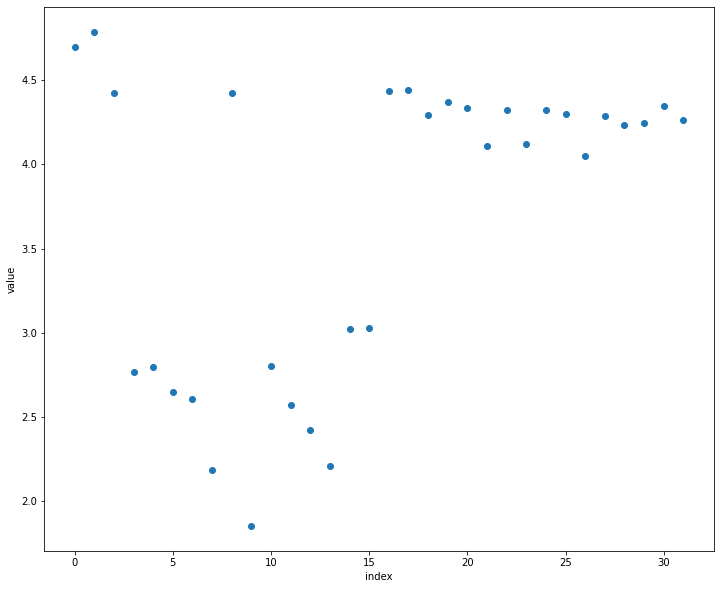

In [31]:
plt.figure(figsize=(12, 10))
plt.scatter( np.arange(len(output_final)),np.array(output_final))
#plt.scatter( np.arange(len(labels.detach().numpy())),np.array(labels.detach().numpy()))
plt.xlabel("index")
plt.ylabel("value")
#plt.xlim(100,200)
plt.show()

# Plot Net

In [62]:
outputs, mu, sigma, z, pred = model(src, lengths)

In [63]:
from torchviz import make_dot

make_dot(outputs, params=dict(list(model.named_parameters()))).render("frag_20_torchviz", format="png")

'frag_20_torchviz.png'

# Property Predictor